# Loading the data

In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

TensorFlow 2.x selected.
2.1.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls '/content/gdrive/My Drive/Colab Notebooks/DL2020/GA3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
pollution_data.csv		 preprocessed_test_data.csv
preprocessed_pollution_data.csv  preprocessed_train_data.csv


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f82a19a1080>,
      dtype=object)

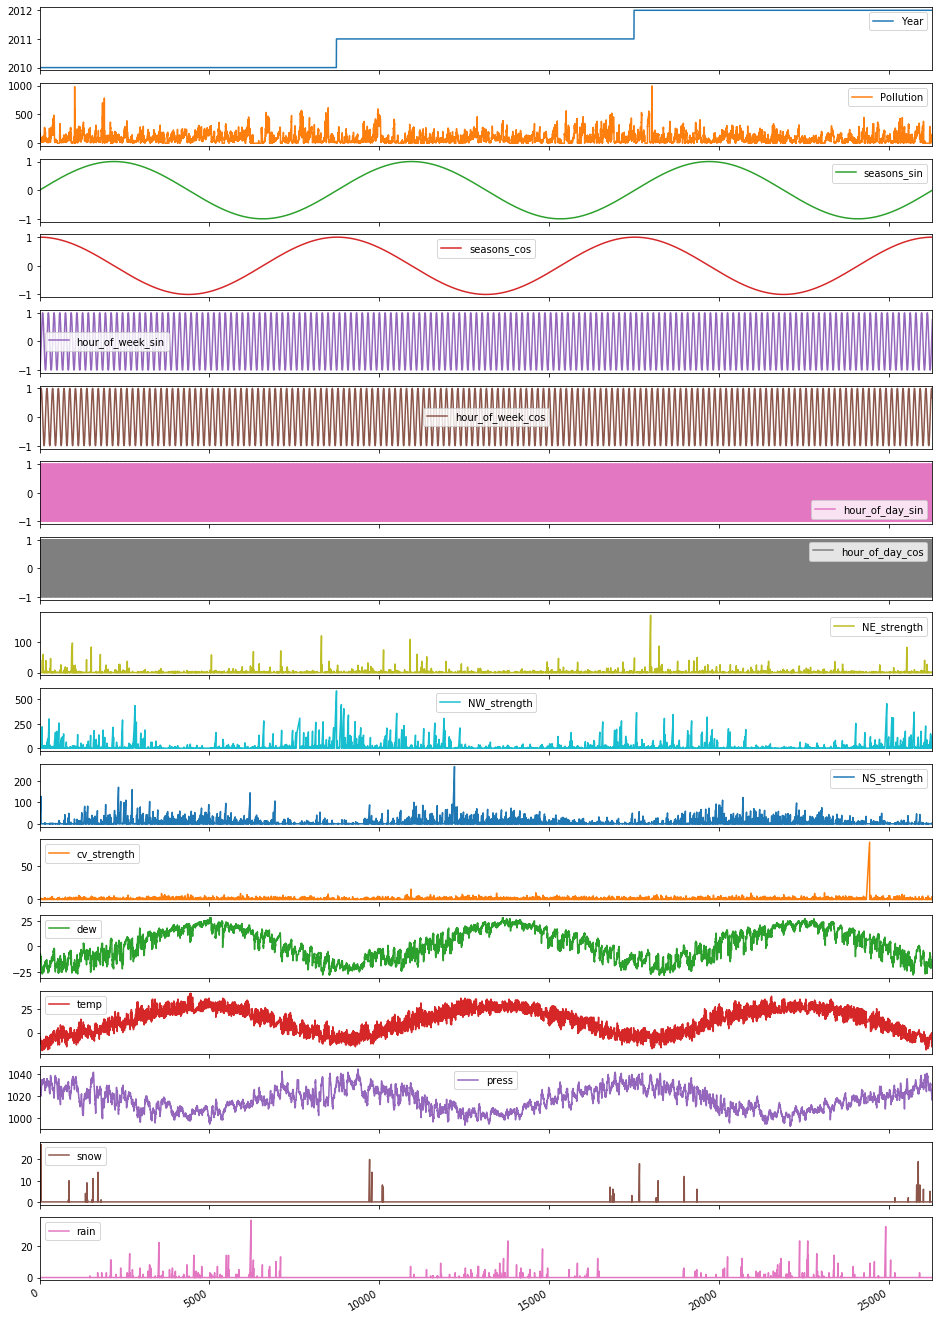

In [9]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/DL2020/GA3/'
TRAINDATAALLFILE = DATAPATH+'preprocessed_train_data_all.csv'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_all_dataset = read_csv(TRAINDATAALLFILE, header=0, index_col=0)
train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html
train_dataset.plot(subplots=True,figsize=(16,26))

## Extract train, validate and test features and labels

In the code below, we will split of an arbitrary number of 5000 samples at the end of the training set as validation data. It is up to you to decide how much data you split off.# New Section

In [13]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out
features = np.arange(2,17)
pollution = 1

# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)
train_all_values = np.asarray(train_all_dataset.values[:,features],dtype=np.float32)
train_all_labels = np.asarray(train_all_dataset.values[:,pollution],dtype=np.float32)
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)

print(train_all_values.shape)
print(train_all_labels.shape)
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)
print(test_values.shape)
print(test_labels.shape)

(35040, 15)
(35040,)
(26280, 15)
(26280,)
(8760, 15)
(8760,)
(8760, 15)
(8760,)


## Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section). 

Although we already did this before, the code below gives an example (adapt teh code after you've defined a validation set:

In [20]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer # BAD for this case
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer # BEST for this case

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...
SS1 = PowerTransformer()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = PowerTransformer()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f829f58ca20>,
      dtype=object)

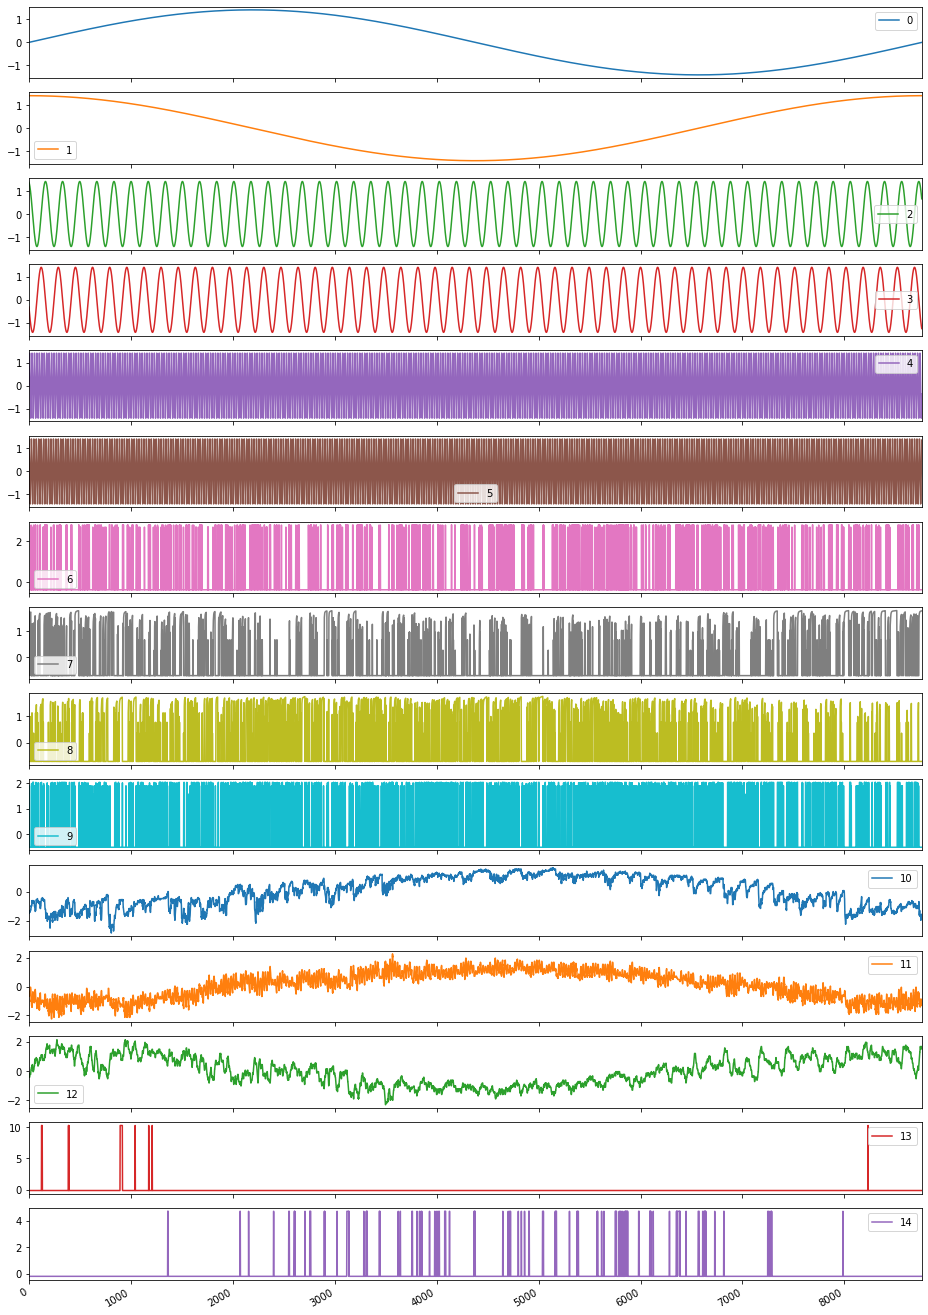

In [21]:
pd.DataFrame(test_scaled).plot(subplots=True,figsize=(16,26))

# Step 1

# Step 2

# Step 3

# Step 4